<a href="https://colab.research.google.com/github/klajosw/python/blob/master/kl_py_map_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="left"> 
    <img src="https://raw.githubusercontent.com/klajosw/python/master/kl_mie_python_logo_250.jpg" 
         align="left" width="251" height="251">
    
</p>


<p> </p>

# Térképi megjelenítése Python programmal


## osmnx és networkx használata

<https://klajosw.blogspot.com/>


---


In [ ]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
ox.config(use_cache=True, log_console=True)
## ox.__version__

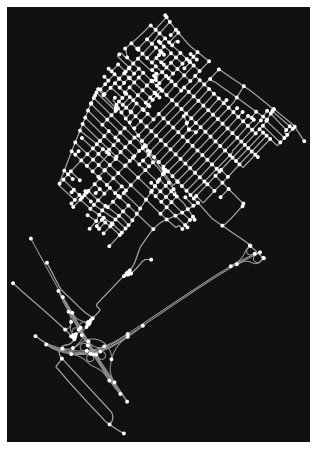

In [ ]:
# Gyál város megjelenítése
G = ox.graph_from_place('Gyál, Hungary', network_type='drive')
fig, ax = ox.plot_graph(G)

In [ ]:
# milyen méretű területet fed le a térkép négyzetméterben?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print('Térkép területe :',graph_area_m,' (m2)')

Térkép területe : 17313634.99437639  (m2)


In [ ]:
# Alap statisztika  // Értelemezése : https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 538,
 'm': 1517,
 'k_avg': 5.639405204460966,
 'intersection_count': 482,
 'streets_per_node_avg': 3.046468401486989,
 'streets_per_node_counts': {0: 0, 1: 56, 2: 0, 3: 345, 4: 137},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.10408921933085502,
  2: 0.0,
  3: 0.6412639405204461,
  4: 0.25464684014869887},
 'edge_length_total': 245871.9269999999,
 'edge_length_avg': 162.07773698088326,
 'street_length_total': 137276.40700000004,
 'street_length_avg': 170.31812282878417,
 'street_segments_count': 806,
 'node_density_km': 31.073775101227834,
 'intersection_density_km': 27.83933010927847,
 'edge_density_km': 14201.057552608745,
 'street_density_km': 7928.803341677732,
 'circuity_avg': 1.0155686389936562,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': 427,
 'clean_intersection_density_km': 24.662643063613913}

In [ ]:
# Térkép mentése geopackage (GIS vagy graphml  formába további feldolgozásra pl.: gephi ...)
ox.save_graph_geopackage(G, filepath='gyal.gpkg')
ox.save_graphml(G, filepath='gyal.graphml')

---

## Városok utcáinak megjelenítése

Ábrázolhatjuk az utcai hálózatot és színezzük annak széleit (utcáit) a viszonylagos közelségük szerint.


'drive'         - get drivable public streets (but not service roads)

'drive_service' - get drivable streets, including service roads

'walk'          - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)

'bike'          - get all streets and paths that cyclists can use

'all'           - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)

'all_private'   - download all OSM streets and paths, including private-access ones


---

In [ ]:
# konvertáljuk a gráfot vonalas gráfra, hogy az élek csomópontokká váljanak, és fordítva

edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

In [ ]:
# színes élek az eredeti grafikonról, a közelség a vonaldiagramról 
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

---

## Útvonal tervezés

---

In [ ]:
# sebesség és menet idő figyelembe vétele
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [ ]:
# Gyál Pozsonyi utca 39 és a Kakucsi Pékség Kft távolság
orig = ox.get_nearest_node(G, (47.384983,19.2009673))
dest = ox.get_nearest_node(G, (47.37571,19.2196368))

In [ ]:
# legrövidebb idelyű utvonal keresés és megjelenítés
route = nx.shortest_path(G, orig, dest, weight='travel_time')
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [ ]:
# Milyen hosszú a megtett út
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
print('Út hossza: ', sum(edge_lengths), 'm')

In [ ]:
# Légvonalbani távolság mennyi?
lv_hossz=ox.distance.great_circle_vec(G.nodes[orig]['y'], G.nodes[orig]['x'],
                             G.nodes[dest]['y'], G.nodes[dest]['x'])
print('Légvonalban: ', lv_hossz, 'm')


In [ ]:
# Magasság értékekk hozzáadása
# Google API key szükséges ehhez!!!
from keys import google_elevation_api_key
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)
G = ox.add_edge_grades(G)
nc = ox.plot.get_node_colors_by_attr(G, 'elevation', cmap='plasma')
fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color='#333')

---

## Hely térképen történő keresés

finomitó jellegű keresés összeállításával

---

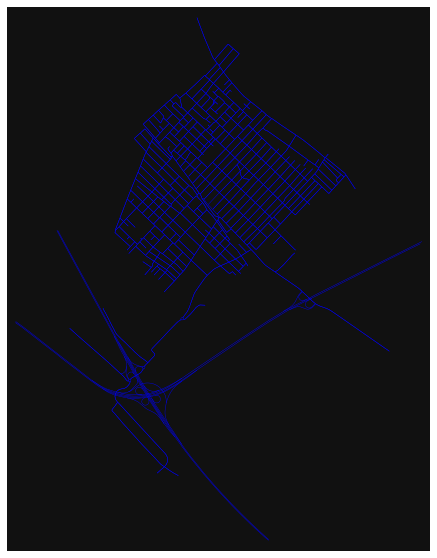

In [ ]:
# finomitó lekérdezés összeállítás
place = {'city'   : 'Gyál',
         'state'  : 'Pest',
         'country': 'Hungary'}
G = ox.graph_from_place(place, network_type='drive', truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color='b', edge_linewidth=0.4)

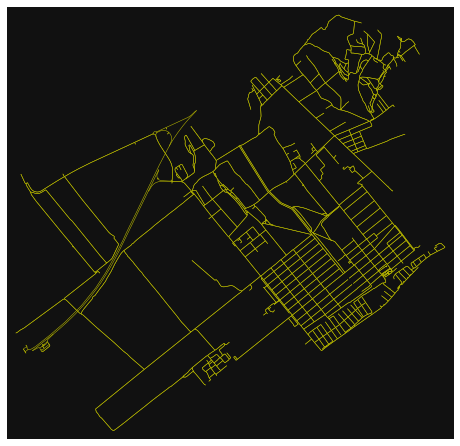

In [ ]:
# Tárnok község kiválasztása
G = ox.graph_from_place('Tárnok, Hungary', network_type='all')
fig, ax = ox.plot_graph(G, node_size=0, edge_color='y', edge_linewidth=0.5)

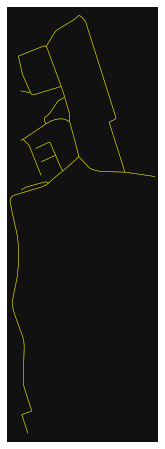

In [ ]:
#Ha csak a poziciót tudjuk akkor a távolság megadásával is kérhetünk térkép adatokat
wurster_hall = (47.3681187,18.7689793) ## Tárnok vasulállomás
one_mile = 2500                        ## méter
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type='drive')
fig, ax = ox.plot_graph(G, node_size=0, edge_color='y', edge_linewidth=0.5)

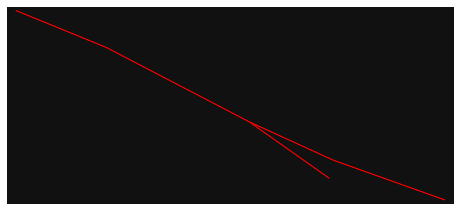

In [ ]:
## Vonat vonal megjelenítése
G = ox.graph_from_place('Kispest, Budapest, Hungary',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"~"subway"]')

fig, ax = ox.plot_graph(G, node_size=0, edge_color='r', edge_linewidth=0.8)

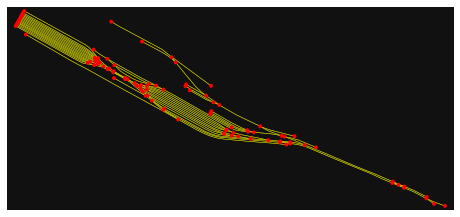

In [ ]:
G = ox.graph_from_place('Budapest, Hungary',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"~"subway"]')

fig, ax = ox.plot_graph(G, edge_color='y', node_color='r', edge_linewidth=0.5)

---

## Érdekes helyek keresése

---

In [ ]:
# minden érdekes hely kikeresése
tags = {'amenity' : True,
        'landuse' : ['retail', 'commercial'],
        'highway' : 'bus_stop'}
gdf = ox.pois_from_place('Budapest, Hungary', tags)
gdf.shape


(30816, 864)

In [ ]:
# Bankok listázása
G1= gdf[gdf['amenity']=='bank'].dropna(axis=1, how='any')
##fig, ax = ox.plot_graph(G1, node_size=0, edge_color='r', edge_linewidth=0.2)

In [ ]:
# busz megállók listája
gdf[gdf['highway']=='bus_stop'].dropna(axis=1, how='any').head()

,osmid,geometry,element_type,highway
84640378,84640378,POINT (19.00488 47.46213),node,bus_stop
149662580,149662580,POINT (19.00551 47.43063),node,bus_stop
149663268,149663268,POINT (19.00145 47.42595),node,bus_stop
149663603,149663603,POINT (18.99979 47.42592),node,bus_stop
151134474,151134474,POINT (19.03209 47.44188),node,bus_stop


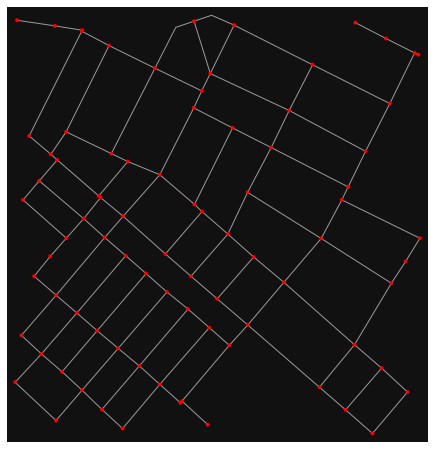

In [ ]:
location_point =  (47.4274747,19.2058965) ## Budapest, Kézdivásárhely utca 9

# térkép megjelenitése pozició és távolság megadásával minden utkereszteződéssel
G = ox.graph_from_point(location_point, dist=500,   dist_type='bbox', network_type='drive')
fig, ax = ox.plot_graph(G, node_color='r')

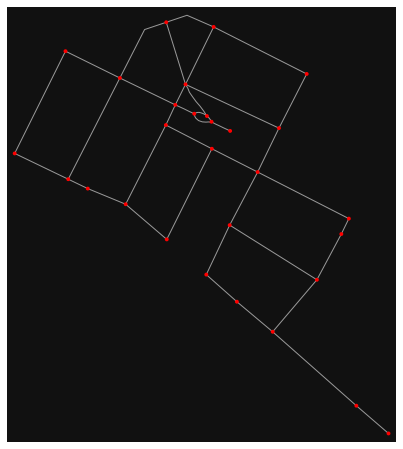

In [ ]:
# megadott ponttol megadott tábvolságon belül lévő pontokból épít hálozatot (térképet)
G = ox.graph_from_point(location_point, dist=500, dist_type='network')
fig, ax = ox.plot_graph(G, node_color='r')

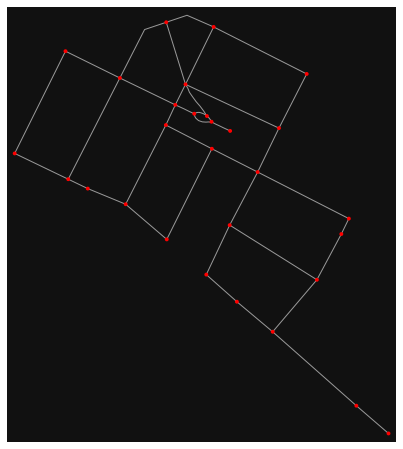

In [ ]:
## gyalogos forgalmú utakkal
G = ox.graph_from_point(location_point, dist=500, dist_type='network', network_type='walk')
fig, ax = ox.plot_graph(G, node_color='r')


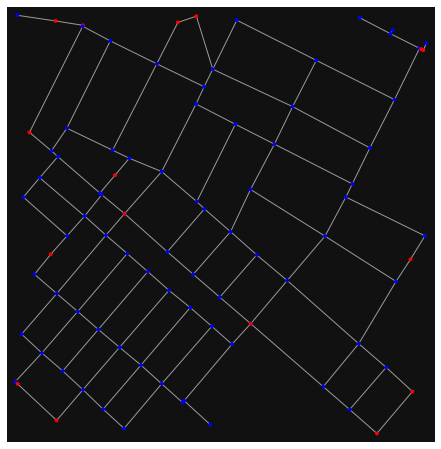

In [ ]:
location_point = (47.4274747,19.2058965) ## Budapest, Kézdivásárhely utca 9
G = ox.graph_from_point(location_point, network_type='drive_service', dist=500, simplify=False)

nc = ['b' if ox.simplification._is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

---

## Egyszerűsített hálózat ábrázolása, hosszak jelzése színezéssel

---

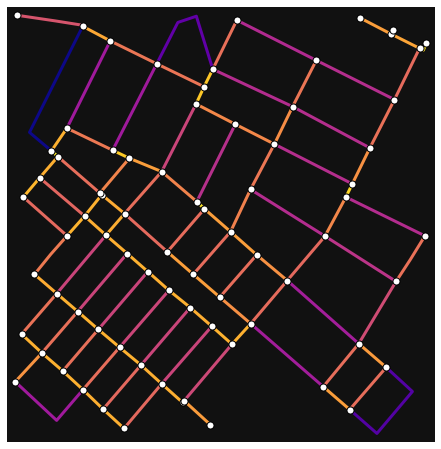

In [ ]:
G = ox.simplify_graph(G)
ec = ox.plot.get_edge_colors_by_attr(G, attr='length', cmap='plasma_r')
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=50,
                        edge_color=ec, edge_linewidth=3)

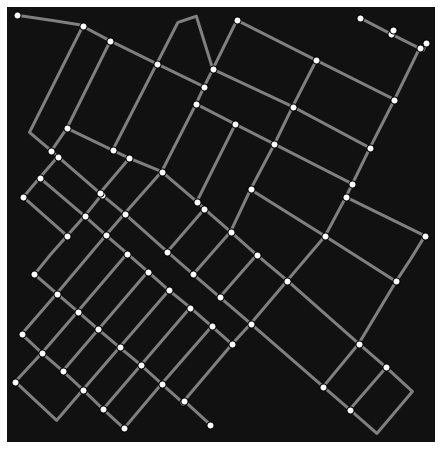

In [ ]:
ec = ['gray' if k == 0 or u == v else 'r' for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=50,
                        edge_color=ec, edge_linewidth=3)

In [ ]:
## egyírányú utak jelőlése
#ec = ['r' if data['oneway'] else 'w' for u, v, key, data in G.edges(keys=True, data=True)]
#fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

G.edges(keys=True, data=True)
for u, v, key, data in G.edges(keys=True, data=True):
    print( data['oneway'] )
    

KeyError: 'oneway'

---  

## Térkép mentése állományba

---

In [ ]:
# Az utca térkép mentése GeoPackage formátumba  GIS munkához
ox.save_graph_geopackage(G, filepath='BP18_network.gpkg')

In [ ]:
# Az utca térkép mentése GraphML formátumba OSMnx vagy networkx vagy gephi munkához
ox.save_graphml(G, filepath='BP18_network.graphml')


In [ ]:
# Az utca térkép mentése shapefilek könyvtárba  (több állomány képződik)
ox.save_graph_shapefile(G, filepath='BP18_network_dir')

In [ ]:
# Az utca térkép mentése SVG formátumba
fig, ax = ox.plot_graph(G, show=False, save=True, close=True, filepath='gyal.svg')

In [ ]:
# Az utca térkép mentése pontok mentése a geopackage formátumba geopandas használathoz
gdf = ox.pois_from_place(place, tags={'amenity':True})
gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
gdf.to_file('gyal_pois.gpkg', driver='GPKG')

In [ ]:
# Az utca térkép épületek mentése geopackage formátumba geopandas használathoz
gdf = ox.footprints_from_place(place)
gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
gdf.to_file('gyal_building_footprints.gpkg', driver='GPKG')

In [ ]:
# Az utca térkép mentése .osm xml file formátumba
ox.config(all_oneway=True, log_console=True, use_cache=True)
G = ox.graph_from_place('Gyál, Hungary', network_type='drive')
ox.save_graph_xml(G, filepath='gyal.osm')

---

## Térkép betőltése állományból

---

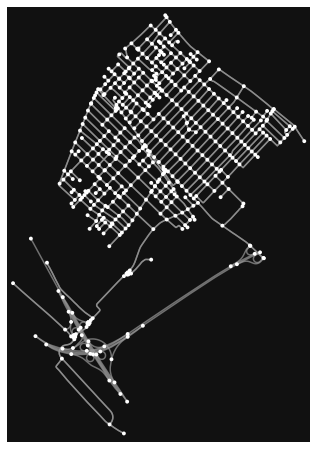

In [ ]:
G = ox.load_graphml(filepath='gyal.graphml')
fig, ax = ox.plot_graph(G, edge_linewidth=1.5, edge_alpha=0.7)

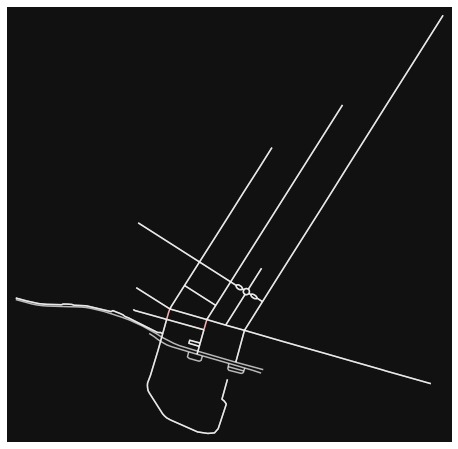

In [ ]:
## Térkép betöltése osm extract fileből
G = ox.graph_from_xml('West-Oakland.osm.bz2')
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)